In [ ]:
#%%

from get_model.config.config import load_config, pretty_print_config

from get_model.run_region import run_zarr as run

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
#%%

%matplotlib inline

cfg = load_config('finetune_tutorial') # load the predefined finetune tutorial config; it's in get_model/config/finetune_tutorial.yaml
cfg.run.run_name='predict_atac' # this is a unique name for this run
cfg.dataset.zarr_path = "./output.zarr" # the tutorial data which contains astrocyte atac & rna
cfg.dataset.celltypes = 'astrocyte' # the celltypes you want to finetune
cfg.dataset.leave_out_chromosomes = 'chr10,chr11'
cfg.run.use_wandb=True # this is a logging system, you can turn it off by setting it to False
cfg.machine.num_devices=1 # this is the number of GPUs you want to use
cfg.machine.batch_size = 32
cfg.training.epochs = 10 # this is the number of epochs you want to train for

In [ ]:
# %%

# Switch model to finetune ATAC model, this model will set all ATAC values for each peak to 1, and use motif information to predict the ATAC values
cfg.model = load_config('model/GETRegionFinetuneATAC').model.model
pretty_print_config(cfg)

run:
  project_name: finetune_tutorial
  run_name: predict_atac
  use_wandb: true
type: region
stage: fit
assembly: hg38
eval_tss: true
log_image: true
model:
  _target_: get_model.model.model.GETRegionFinetuneATAC
  cfg:
    num_regions: 200
    num_motif: 283
    embed_dim: 768
    num_layers: 12
    num_heads: 12
    dropout: 0.1
    output_dim: 1
    flash_attn: false
    pool_method: mean
    region_embed:
      num_regions: ${model.cfg.num_regions}
      num_features: ${model.cfg.num_motif}
      embed_dim: ${model.cfg.embed_dim}
    encoder:
      num_heads: ${model.cfg.num_heads}
      embed_dim: ${model.cfg.embed_dim}
      num_layers: ${model.cfg.num_layers}
      drop_path_rate: ${model.cfg.dropout}
      drop_rate: 0
      attn_drop_rate: 0
      use_mean_pooling: false
      flash_attn: ${model.cfg.flash_attn}
    head_exp:
      embed_dim: ${model.cfg.embed_dim}
      output_dim: 1
      use_atac: false
    mask_token:
      embed_dim: ${model.cfg.embed_dim}
      std: 0.

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
2025-01-02 20:20:26,932 - ERROR - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model = GETRegionFinetuneATAC(
  (loss): GETLoss()
  (metrics): RegressionMetrics(
    (metrics): ModuleDict(
      (atpm): ModuleDict(
        (pearson): PearsonCorrCoef()
        (spearman): SpearmanCorrCoef()
        (r2): R2Score()
      )
    )
  )
  (region_embed): RegionEmbed(
    (embed): Linear(in_features=283, out_features=768, bias=True)
  )
  (encoder): GETTransformer(
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_drop): Dropout(p=0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(app

wandb: Currently logged in as: xf2217 (get-v3). Use `wandb login --relogin` to force relogin


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr4_GL000008v2_random', 'chr5', 'chr6', 'chr7', 'chr7_KI270803v1_alt', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chr22_KI270879v1_alt', 'chrX']



100%|██████████| 1/1 [00:00<00:00, 35.39it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Assigned values = [0.023757264018058777, 0.03167635202407837, 0.04223513603210449, 0.056313514709472656, 0.07508468627929688, 0.1001129150390625, 0.13348388671875, 0.177978515625, 0.2373046875, 0.31640625, 0.421875, 0.5625, 0.75, 1.0]
Skip weight decay list:  {'cls_token', 'pos_embed'}
Param groups = {
  "layer_0_no_decay": {
    "weight_decay": 0.0,
    "params": [
      "cls_token",
      "region_embed.embed.bias"
    ],
    "lr_scale": 0.023757264018058777
  },
  "layer_0_decay": {
    "weight_decay": 0.05,
    "params": [
      "region_embed.embed.weight"
    ],
    "lr_scale": 0.023757264018058777
  },
  "layer_1_no_decay": {
    "weight_decay": 0.0,
    "params": [
      "encoder.blocks.0.norm1.weight",
      "encoder.blocks.0.norm1.bias",
      "encoder.blocks.0.attn.q_bias",
      "encoder.blocks.0.attn.v_bias",
      "encoder.blocks.0.attn.proj.bias",
      "encoder.blocks.0.norm2.weight",
      "e


/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/xf2217/output/finetune_tutorial/predict_atac/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=25). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


atpm_pearson,▁▂▂▃▃▄▄▅▅▆▆▆▇▇▇▇████
atpm_r2,▁▆▄▅▇▇██████████████
atpm_spearman,▁▂▂▃▄▄▄▅▅▆▆▆▇▇▇▇████
epoch,▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇███
train_atpm_loss,█▂▁▁▁▁▂▁
train_loss,█▂▁▁▁▁▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_atpm_loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
atpm_pearson,0.40751
atpm_r2,0.00917


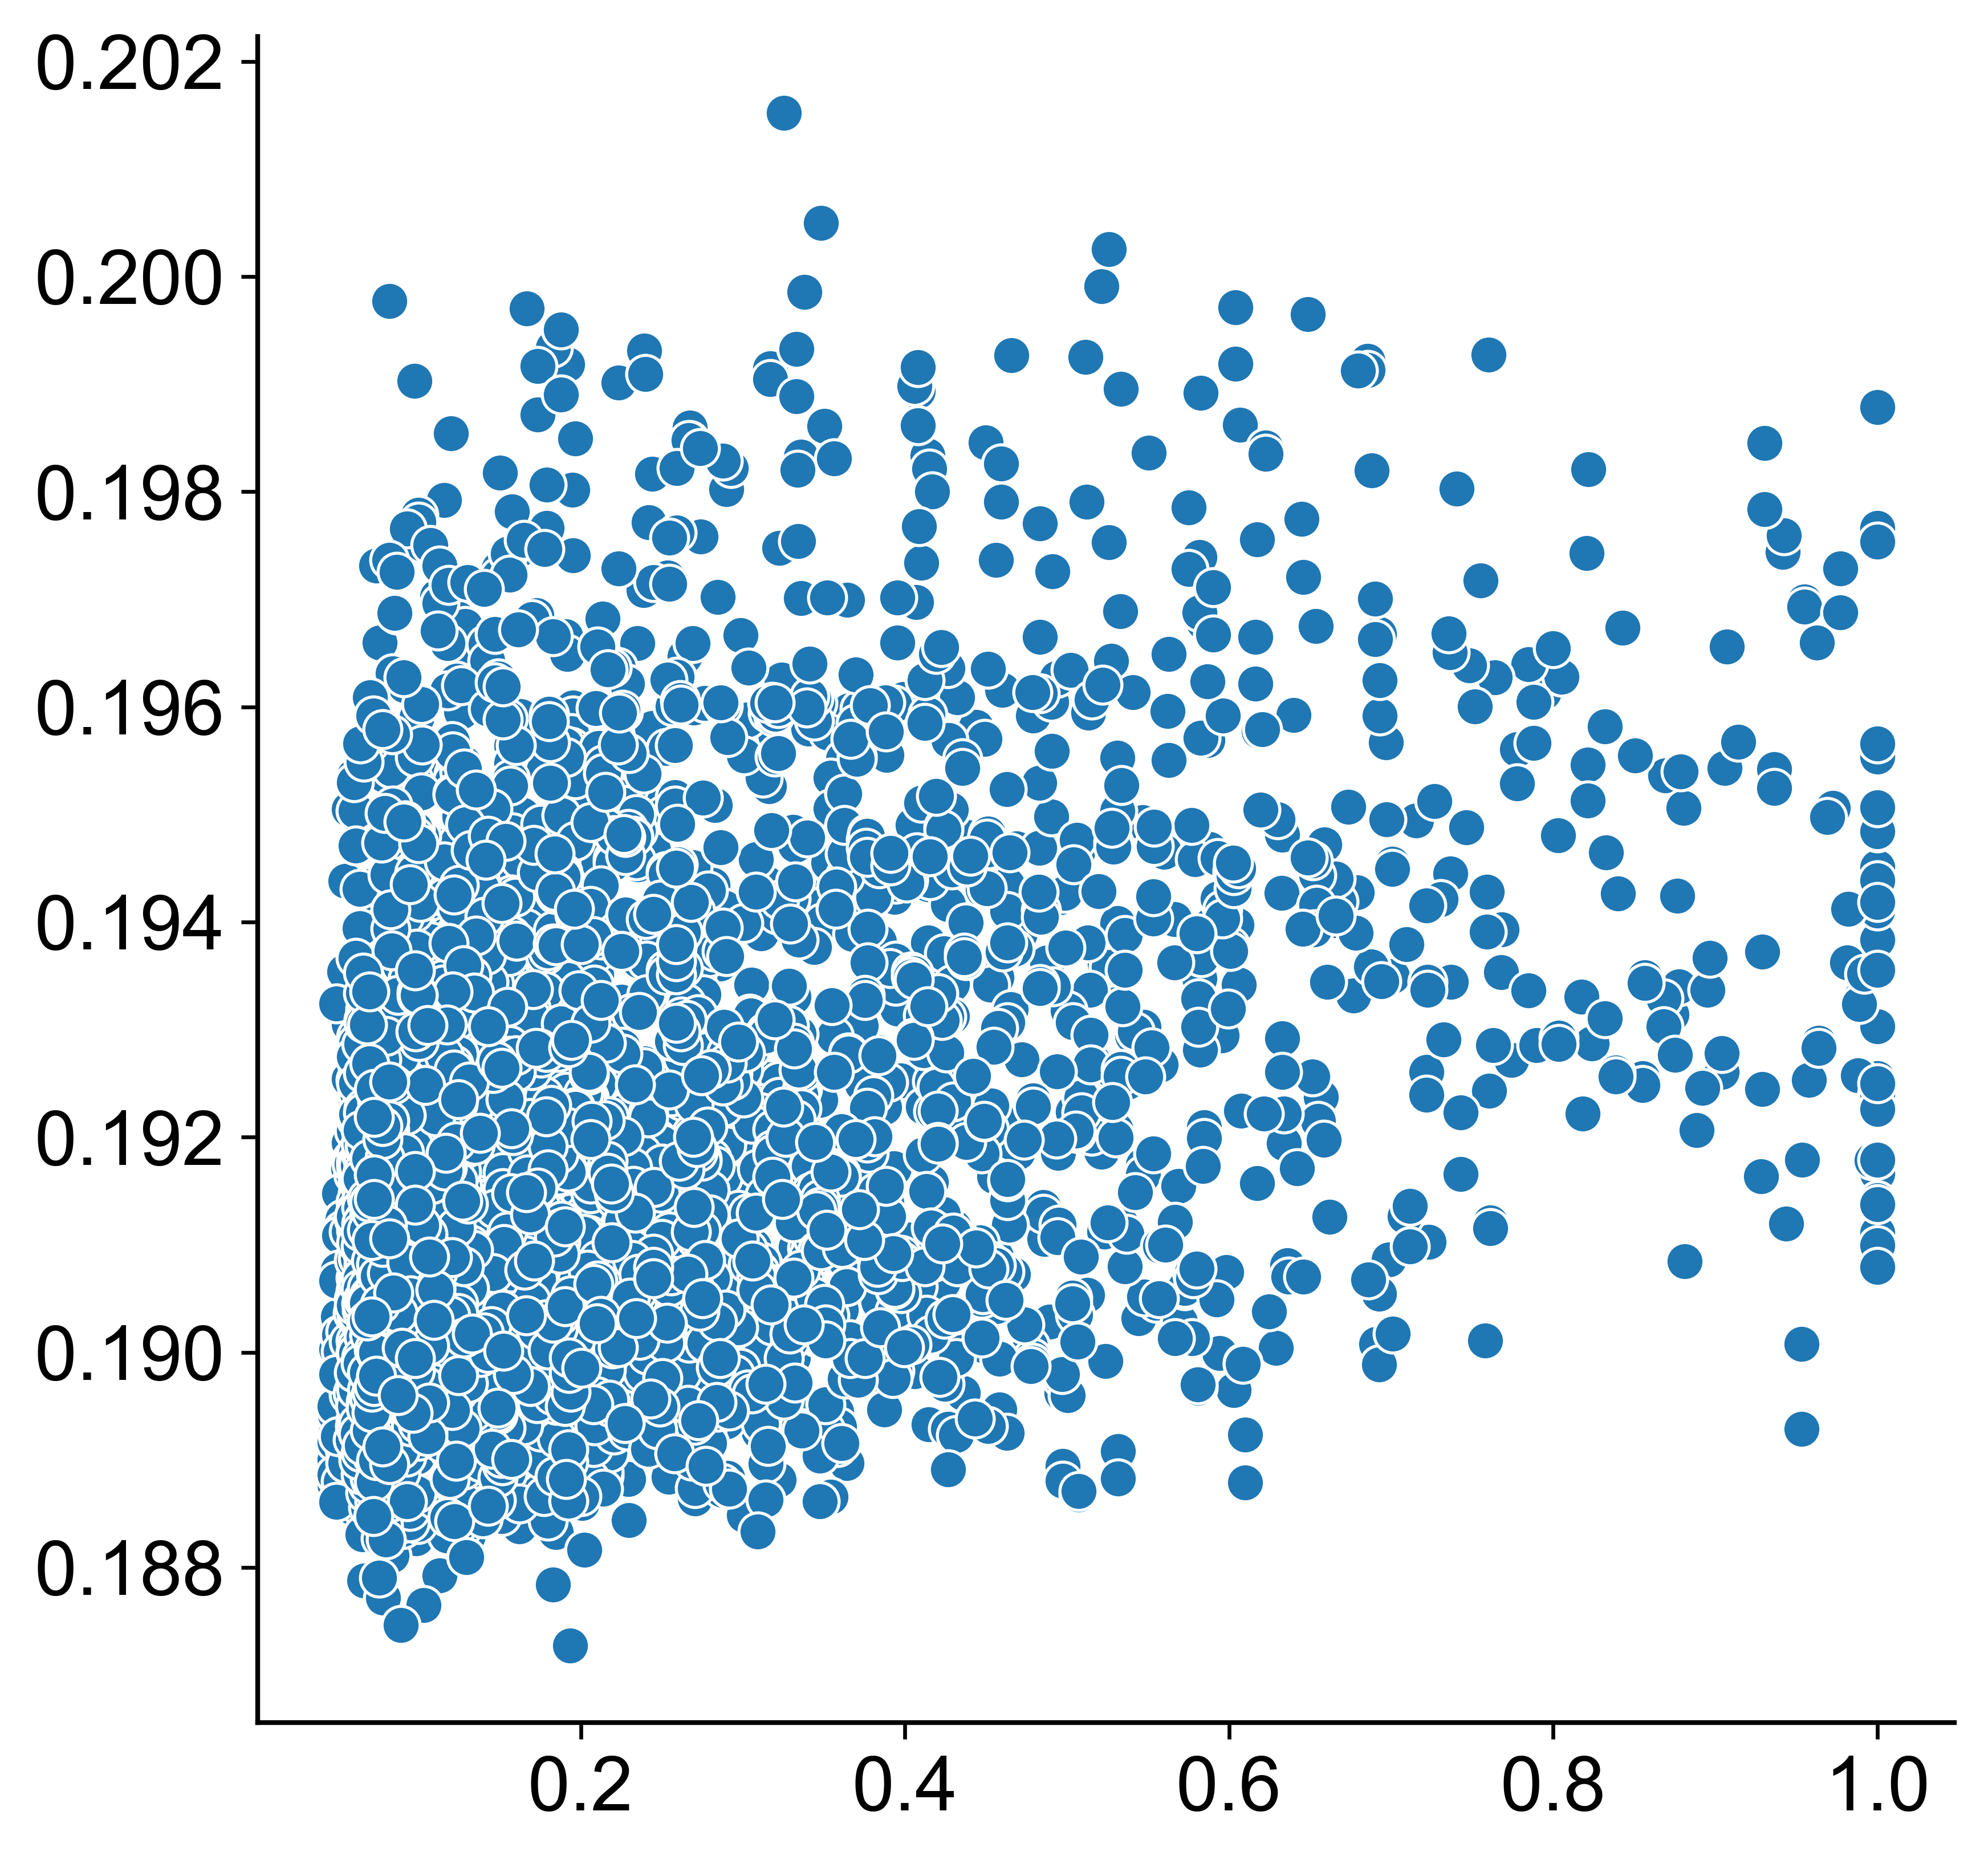

In [ ]:
# %%

# first run the model without initializing with a pretrain checkpoint
cfg.finetune.checkpoint = None
trainer = run(cfg)

In [ ]:
# %%

trainer.callback_metrics

{'train_atpm_loss': tensor(0.5123),
 'train_loss': tensor(0.5123),
 'val_atpm_loss': tensor(0.5022),
 'atpm_pearson': tensor(0.4075),
 'atpm_spearman': tensor(0.3409),
 'atpm_r2': tensor(0.0092),
 'val_loss': tensor(0.5022)}

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Load ckpt from ./checkpoint-799.pth
Load state_dict by model_key = model
Model = GETRegionFinetuneATAC(
  (loss): GETLoss()
  (metrics): RegressionMetrics(
    (metrics): ModuleDict(
      (atpm): ModuleDict(
        (pearson): PearsonCorrCoef()
        (spearman): SpearmanCorrCoef()
        (r2): R2Score()
      )
    )
  )
  (region_embed): RegionEmbed(
    (embed): Linear(in_features=283, out_features=768, bias=True)
  )
  (encoder): GETTransformer(
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_drop): Dropout(p=0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear

100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr4_GL000008v2_random', 'chr5', 'chr6', 'chr7', 'chr7_KI270803v1_alt', 'chr8', 'chr9', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chr22_KI270879v1_alt', 'chrX']



100%|██████████| 1/1 [00:00<00:00, 35.31it/s]

Leave out chromosomes: ['chr10', 'chr11']
Input chromosomes: ['chr10', 'chr11']
Assigned values = [0.023757264018058777, 0.03167635202407837, 0.04223513603210449, 0.056313514709472656, 0.07508468627929688, 0.1001129150390625, 0.13348388671875, 0.177978515625, 0.2373046875, 0.31640625, 0.421875, 0.5625, 0.75, 1.0]
Skip weight decay list:  {'cls_token', 'pos_embed'}
Param groups = {
  "layer_0_no_decay": {
    "weight_decay": 0.0,
    "params": [
      "cls_token",
      "region_embed.embed.bias"
    ],
    "lr_scale": 0.023757264018058777
  },
  "layer_0_decay": {
    "weight_decay": 0.05,
    "params": [
      "region_embed.embed.weight"
    ],
    "lr_scale": 0.023757264018058777
  },
  "layer_1_no_decay": {
    "weight_decay": 0.0,
    "params": [
      "encoder.blocks.0.norm1.weight",
      "encoder.blocks.0.norm1.bias",
      "encoder.blocks.0.attn.q_bias",
      "encoder.blocks.0.attn.v_bias",
      "encoder.blocks.0.attn.proj.bias",
      "encoder.blocks.0.norm2.weight",
      "e


/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/xf2217/output/finetune_tutorial/predict_atac_with_pretrain/checkpoints exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=25). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

/home/xf2217/mambaforge-pypy3/envs/get_started/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

atpm_pearson,▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇████
atpm_r2,▁▅▁▆▆▆▆▆▆▆▇▇▇▇██████
atpm_spearman,▁▃▄▅▆▆▆▇▇▇▇▇▇███████
epoch,▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇███
train_atpm_loss,█▂▂▂▂▁▁▂
train_loss,█▂▂▂▂▁▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_atpm_loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
atpm_pearson,0.63391
atpm_r2,0.39952


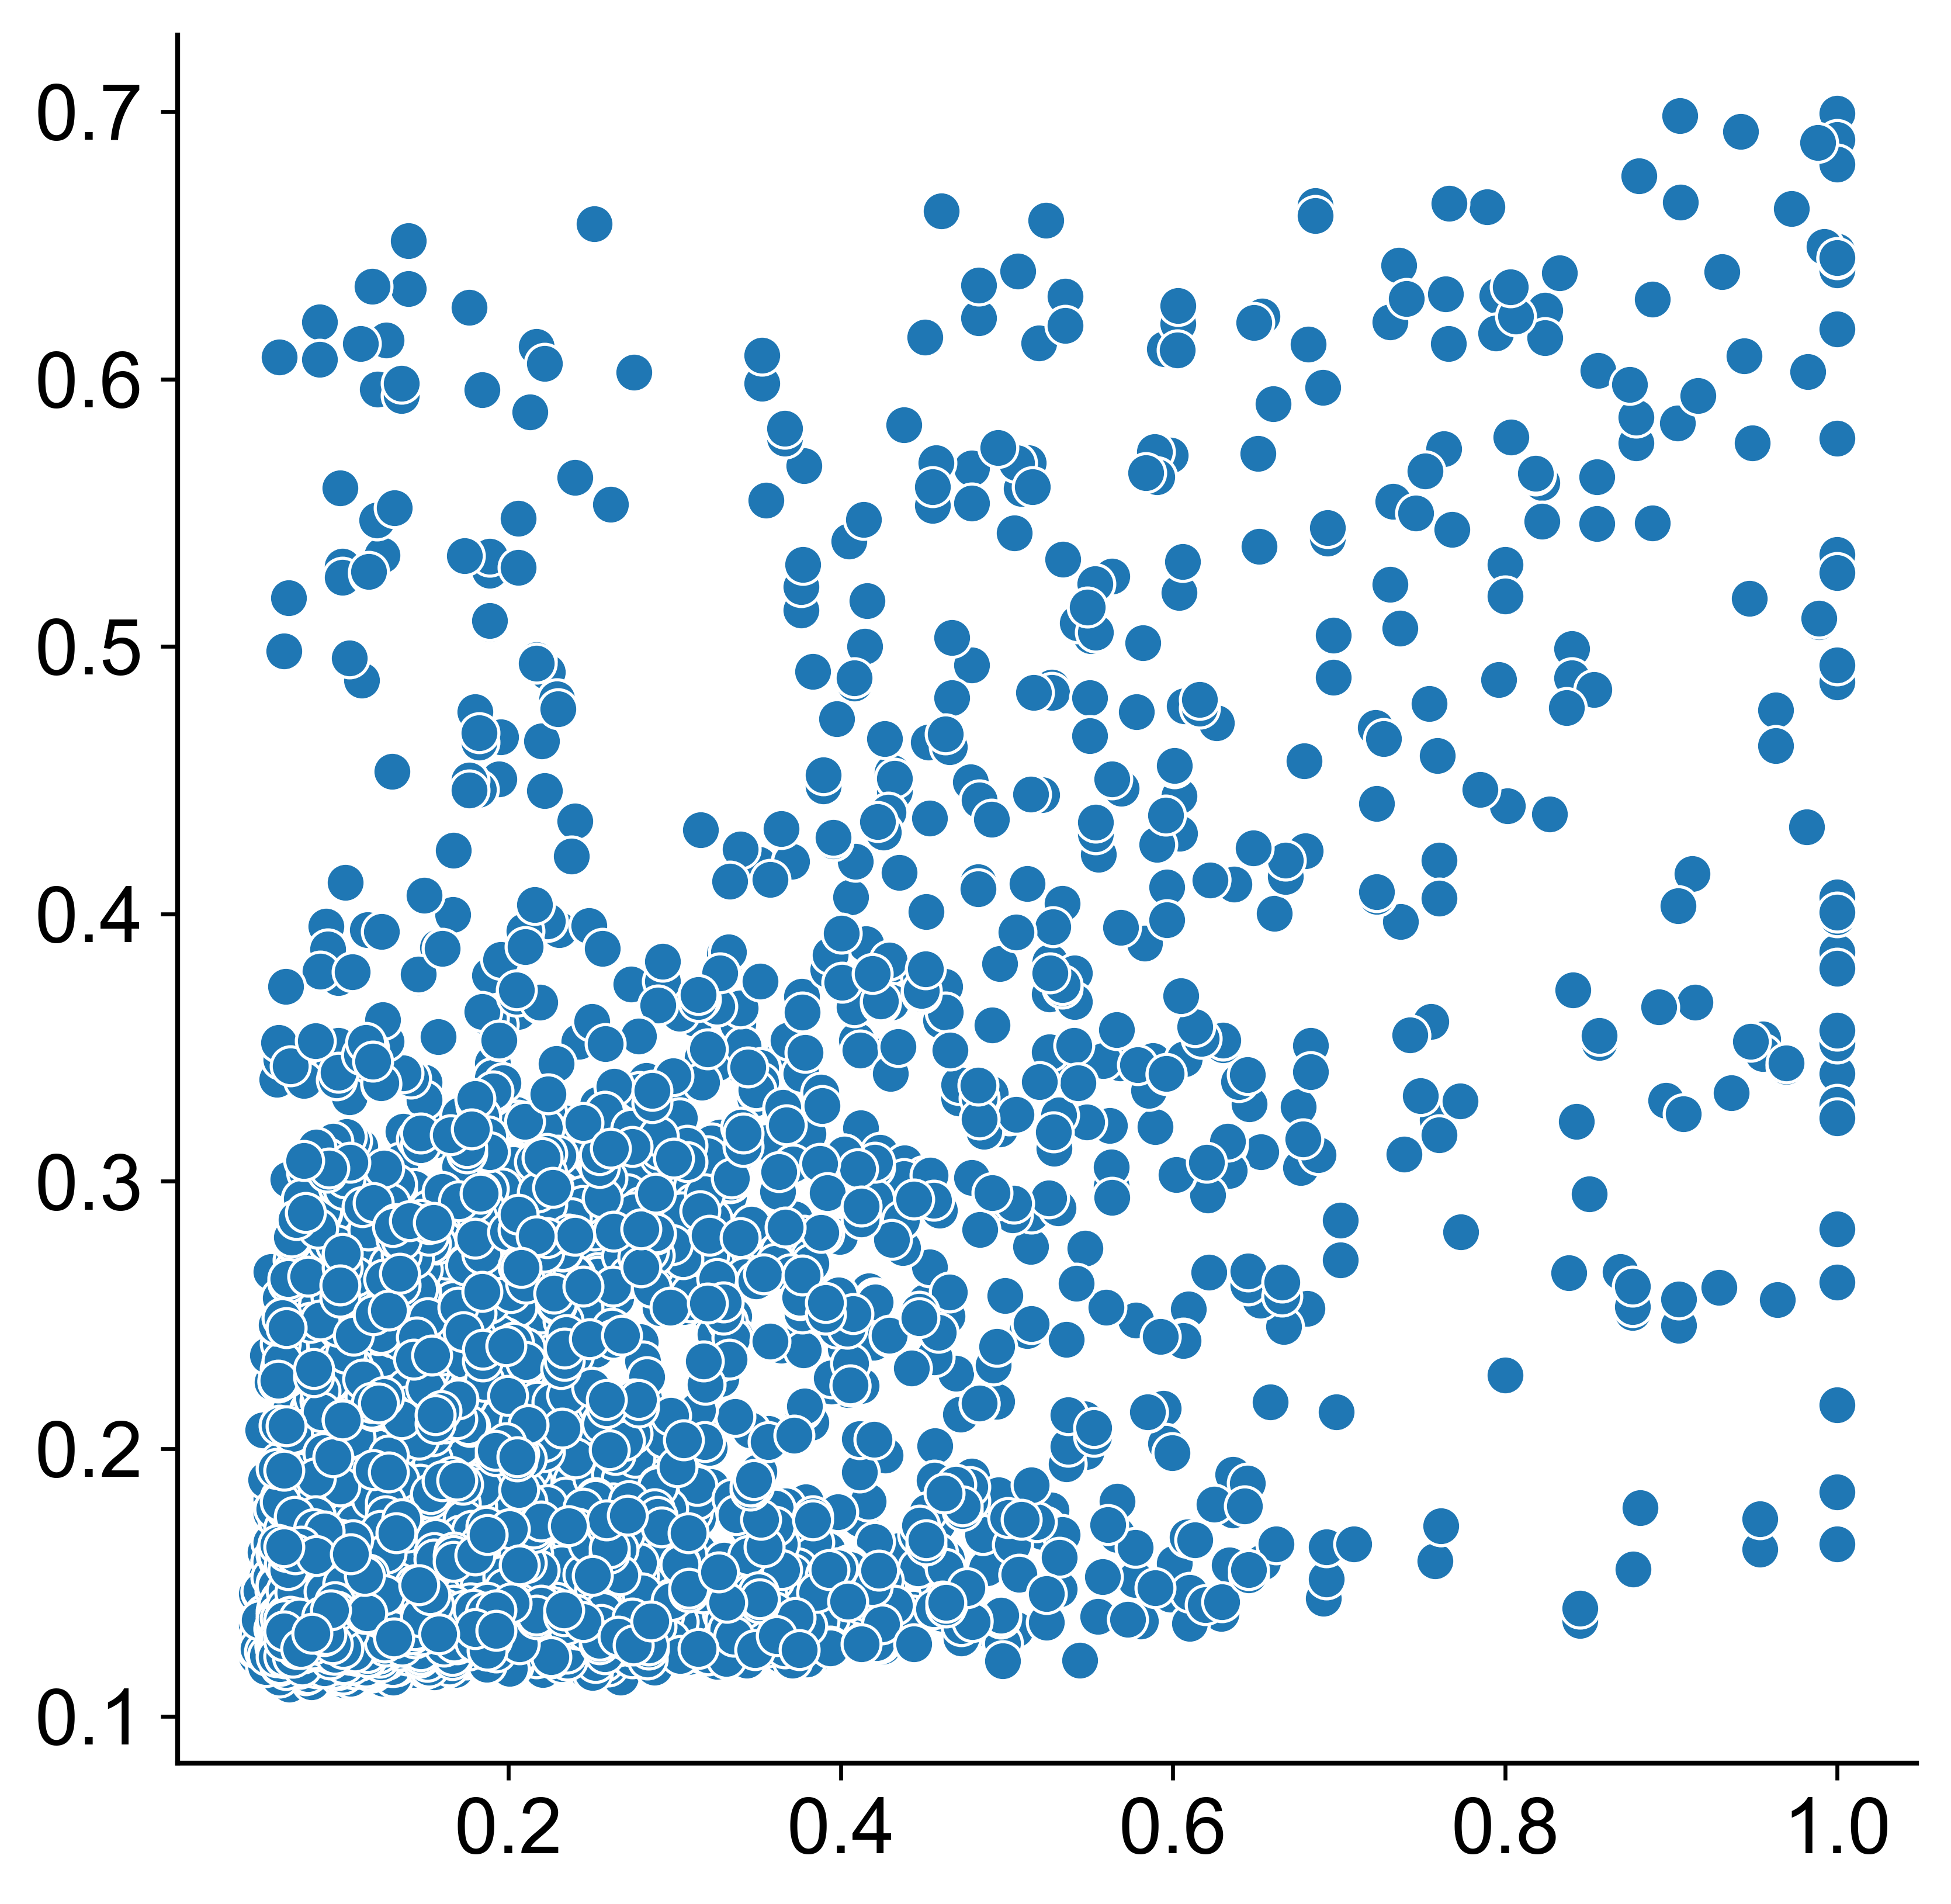

In [ ]:
# %%

# now train the model with a pretrain checkpoint
#  download from https://us-east-1.console.aws.amazon.com/s3/object/2023-get-xf2217?region=us-east-1&bucketType=general&prefix=get_demo/checkpoints/regulatory_inference_checkpoint_fetal_adult/pretrain_fetal_adult/checkpoint-799.pth
#! aws s3 cp s3://2023-get-xf2217/get_demo/checkpoints/regulatory_inference_checkpoint_fetal_adult/pretrain_fetal_adult/checkpoint-799.pth ./checkpoint-799.pth
cfg.finetune.checkpoint = './checkpoint-799.pth'
cfg.run.run_name = 'predict_atac_with_pretrain'
cfg.finetune.strict = False # need this because the original checkpoint has a mask-prediction header
trainer = run(cfg)

In [ ]:
# %%

trainer.callback_metrics

{'train_atpm_loss': tensor(0.5031),
 'train_loss': tensor(0.5031),
 'val_atpm_loss': tensor(0.4788),
 'atpm_pearson': tensor(0.6339),
 'atpm_spearman': tensor(0.4566),
 'atpm_r2': tensor(0.3995),
 'val_loss': tensor(0.4788)}

In [ ]:
# %%

# Seems pretraining checkpoint deos help with the convergence rate; altough both model is not undertrained